# LENDING CLUB

* __Autor_1:__ Gonzalo Carretero Ursúa
* __Autor_2:__ Sergio Casares Fernández

### Introduction

Typically, commercial and non-commercial banks are the main lenders for loans. In contrast of those, Lending Club (LC) is a peer-to-peer online lending  platform.  It  is the  world’s largest  marketplace connecting  borrowers and  investors, where consumers and small business owners lower the cost of their credit and enjoy a better experience than traditional bank lending, and investors earn attractive risk-adjusted returns

## Index:
* [1. Library and Dataset import](#first-bullet)
* [2. Variables Dictionary](#second-bullet)
* [3. A priori observations selection](#third-bullet)
* [4. Colective and individual dataset division](#fourth-bullet)
* [5. EDA (Exploratory Data Analisis)](#fifth-bullet)
* [6. Dataframes convertion](#sixth-bullet)
* [7. Bibliography](#seventh-bullet)


<a name= 'first-bullet'></a>

# 1. Library and Dataset import

In [1]:
#Basic operations and visualization
import pandas as pd 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

#Column transformation
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
DF = pd.read_csv('Loan_joined.csv', delimiter = ',')
DF.shape

C:\Users\usuario\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,20,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(884884, 152)

#### Drop duplicates

In [3]:
DF = DF.drop_duplicates() 
#There is no duplicates in the dataset

<a name= 'second-bullet'></a>

# 2. Variables Dictionary


In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [5]:
data_dictionary = pd.read_excel('LCDataDictionary.xlsx').dropna()
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'feature', 'Description': 'description'})

to_join_df = pd.DataFrame(DF.dtypes,columns=['dtypes'])
to_join_df.reset_index(inplace=True)
to_join_df.rename(columns = {'index':'feature'}, inplace = True)
to_join_df["%data_missing"] = (DF.isnull().sum()/DF.shape[0]*100).values

data_preview = to_join_df.merge(data_dictionary, on = 'feature',how ='left')
display_all(data_preview.style.set_properties(subset=['description'], **{'width': '1000px'}))

,feature,dtypes,%data_missing,description
0,Unnamed: 0,int64,0.000000,nan
1,id,object,0.000000,A unique LC assigned ID for the loan listing.
2,member_id,float64,100.000000,A unique LC assigned Id for the borrower member.
3,loan_amnt,float64,0.000904,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
4,funded_amnt,float64,0.000904,The total amount committed to that loan at that point in time.
5,funded_amnt_inv,float64,0.000904,The total amount committed by investors for that loan at that point in time.
6,term,object,0.000904,The number of payments on the loan. Values are in months and can be either 36 or 60.
7,int_rate,object,0.000904,Interest Rate on the loan
8,installment,float64,0.000904,The monthly payment owed by the borrower if the loan originates.
9,grade,object,0.000904,LC assigned loan grade


<a name= 'third-bullet'></a>

# 3. A priori observations selection

We drop  'Current' and 'nan' observations from the 'loan_status' column, people who haven´t finished their loans don´t give any value to our goal of prediction and they are unrelevant.

In [6]:
DF.loan_status.unique()

array(['Current', 'Fully Paid', 'In Grace Period', 'Late (31-120 days)',
       'Late (16-30 days)', 'Charged Off', 'Default', nan], dtype=object)

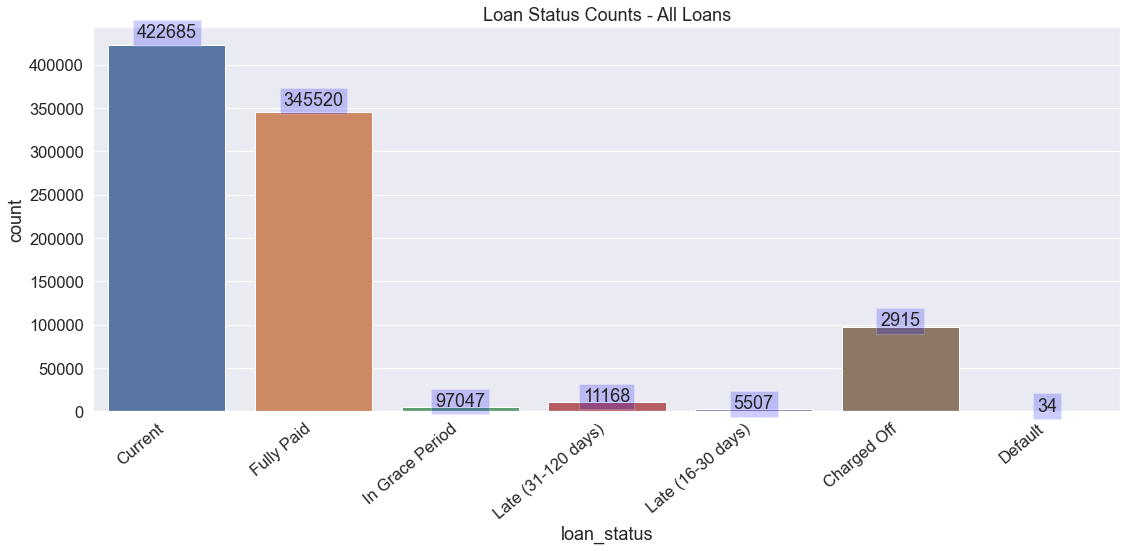

In [7]:
sn.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

ax = sn.countplot(x="loan_status", data=DF) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Loan Status Counts - All Loans")

plt.tight_layout()

vals = DF["loan_status"].value_counts()
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + height*.02,
            vals[idx], bbox=dict(facecolor='blue', alpha=0.2),
            ha="center")

In [8]:
DF.loan_status.value_counts()

Current               422685
Fully Paid            345520
Charged Off            97047
Late (31-120 days)     11168
In Grace Period         5507
Late (16-30 days)       2915
Default                   34
Name: loan_status, dtype: int64

In [9]:
DF = DF[DF.loan_status.isin(['Fully Paid', 'In Grace Period', 'Late (31-120 days)',
       'Late (16-30 days)', 'Charged Off', 'Default'])]
DF.shape, DF.loan_status.unique()

((462191, 152),
 array(['Fully Paid', 'In Grace Period', 'Late (31-120 days)',
        'Late (16-30 days)', 'Charged Off', 'Default'], dtype=object))

### 3.1.Dummy Conversion

In order to predict, we have to convert the dependent variable in a dummy one, in this case, we will divide in two separate values, 1 for people who fully paid the loan and 0 is for all observations where the payment was charged off or delayed in the payment.

In [10]:
DF['loan_acceptance'] = DF['loan_status'].map({'Fully Paid':1,
                                               'In Grace Period':0,
                                               'Late (31-120 days)':0,
                                               'Late (16-30 days)':0,
                                               'Charged Off':0,
                                               'Default':0})

print("Current shape of dataset :",DF.shape)

Current shape of dataset : (462191, 153)


### 3.2.Observation sampling

In this case, we realize that people who pay represent the 75% of the total observations, meanwhile people who haven´t paid and delayed in their payment represent the 25% of the total observations.

We believe there is no neccesity in either oversampling or undersampling both of the groups due to the fact that a 1:4 proportion is acceptable for this king of data.

In [11]:
DF.shape[0]

462191

In [12]:
DF.loan_acceptance.value_counts() #porcentaje

1    345520
0    116671
Name: loan_acceptance, dtype: int64

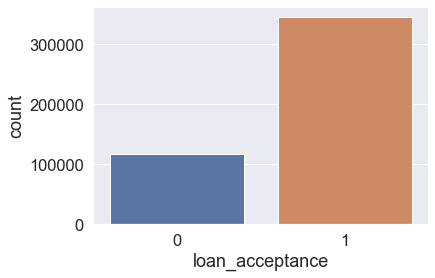

In [14]:
ax = sn.countplot(x="loan_acceptance", data=DF)

<a name= 'fourth-bullet'></a>

# 4. Colective and individual dataset division

We have realised that there are two types of applications, individual and joint app, we have realised that there are significant diferences between both groups so we have decided to split the dataset for both cases.

### 4.1. Individual

In [15]:
DF_UNO = DF[DF['application_type'] == 'Individual']

lista_ind = ['loan_acceptance','acc_now_delinq','acc_open_past_24mths','all_util','annual_inc','avg_cur_bal','bc_util',
             'collections_12_mths_ex_med','delinq_2yrs', 'delinq_amnt','dti','emp_length','home_ownership',
             'il_util','inq_fi','inq_last_12m','inq_last_6mths','installment','int_rate','loan_amnt','max_bal_bc',
             'mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op','mort_acc','mths_since_last_delinq',
             'mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq',
             'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
             'num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',
             'num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_act_il','percent_bc_gt_75','revol_bal',
             'tax_liens','tot_cur_bal','tot_hi_cred_lim','total_acc','total_bal_ex_mort','total_bal_il',
             'total_bc_limit','total_cu_tl','total_rev_hi_lim']
df_ind = DF_UNO[lista_ind]
df_ind.shape

(460541, 54)

In [16]:
#DF con solo las primeras 500 observaciones
mini_df_ind = df_ind.iloc[0:5000,]
mini_df_ind.shape

(5000, 54)

### 4.2. Joint-App

In [17]:
DF_VARIOS = DF[DF['application_type'] == 'Joint App']
lista_col = ['loan_acceptance','acc_now_delinq','acc_open_past_24mths','all_util','annual_inc_joint','avg_cur_bal',
             'bc_util','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti_joint',
             'emp_length','home_ownership','il_util','inq_fi','inq_last_12m','inq_last_6mths',
             'installment','int_rate','loan_amnt','max_bal_bc','mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op',
             'mort_acc','mths_since_last_delinq','mths_since_recent_bc_dlq','mths_since_recent_inq',
             'mths_since_recent_revol_delinq','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',
             'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',
             'num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_act_il',
             'percent_bc_gt_75','revol_bal','tax_liens','tot_cur_bal','tot_hi_cred_lim','total_acc',
             'total_bal_ex_mort','total_bal_il','total_bc_limit','total_cu_tl','total_rev_hi_lim',
             'revol_bal_joint' ,'sec_app_fico_range_low','sec_app_fico_range_high',
             'sec_app_earliest_cr_line' ,'sec_app_inq_last_6mths' ,'sec_app_mort_acc' ,'sec_app_open_acc' ,
             'sec_app_revol_util' ,'sec_app_open_act_il','sec_app_num_rev_accts' ,'sec_app_chargeoff_within_12_mths',
             'sec_app_collections_12_mths_ex_med' ,'sec_app_mths_since_last_major_derog']
df_joint = DF_VARIOS[lista_col]
df_joint.shape

(1650, 67)

In [18]:
mini_df_joint = df_joint.iloc[0:5000,]
mini_df_joint.shape

(1650, 67)

<a name= 'fifth-bullet'></a>

# 5. EDA (Exploratory Data Analisis)

Let´s begin with the Exploratory Data Analisis of our dataset for all the observations and the variables selected.

In [19]:
df_ind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460541 entries, 8 to 884881
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_acceptance                 460541 non-null  int64  
 1   acc_now_delinq                  460541 non-null  float64
 2   acc_open_past_24mths            460541 non-null  float64
 3   all_util                        29866 non-null   float64
 4   annual_inc                      460541 non-null  float64
 5   avg_cur_bal                     460535 non-null  float64
 6   bc_util                         455373 non-null  float64
 7   collections_12_mths_ex_med      460541 non-null  float64
 8   delinq_2yrs                     460541 non-null  float64
 9   delinq_amnt                     460541 non-null  float64
 10  dti                             460541 non-null  float64
 11  emp_length                      435708 non-null  object 
 12  home_ownership  

## 5.1.Categorical Variables

* emp_length
* home_ownership
* int_rate

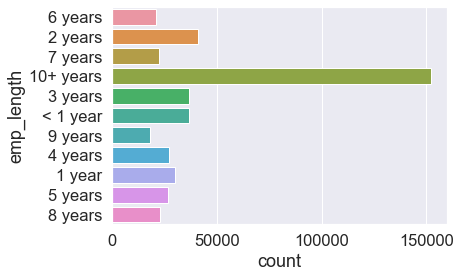

In [20]:
ax = sn.countplot(y="emp_length", data=df_ind)

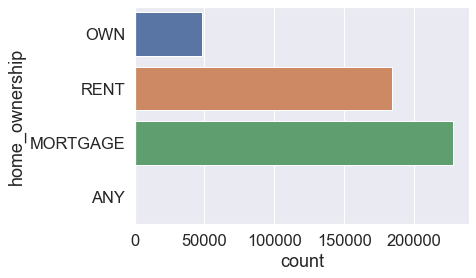

In [21]:
ax = sn.countplot(y="home_ownership", data=df_ind)

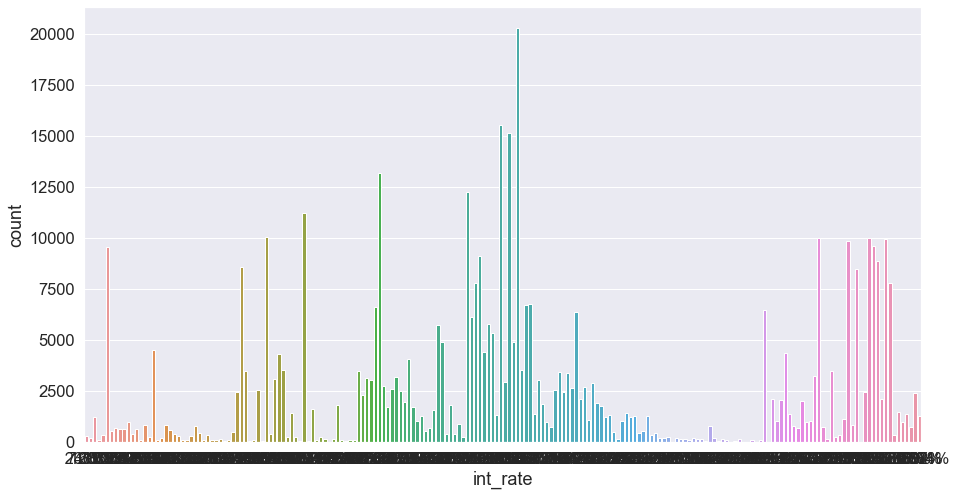

In [22]:
#AUNQUE PUEDA CONSIDERARSE NUMÉRICA, AL PRINCIPIO TIENE UN CARACTER CATEGÓRICO, POSTERIORMENTE SE CONVERTIRÁ A INT64
plt.figure(figsize=(15,8))
ax = sn.countplot(x="int_rate",data=df_ind)

Posteriormente en la ingeniería de variables, modificaremos dichas variables y se convertirán en numéricas.

## 5.2. Variable engineering

Now, for the goal of predict, we are going to transform the categorical variables in numerical for two purposes, realize a better EDA and use this variables in our predictions.

### __emp_length__

In [23]:
def años_casa(x):
    if x == '< 1 year':
        return '0'
    elif x == '1 year':
        return '1'
    elif x == '2 years':
        return '2'
    elif x == '3 years':
        return '3'
    elif x == '4 years':
        return '4'
    elif x == '5 years':
        return '5'
    elif x == '6 years':
        return '6'
    elif x == '7 years':
        return '7'
    elif x == '8 years':
        return '8'
    elif x == '9 years':
        return '9'
    elif x == '10+ years':
        return '10'
    else:
        return '0'
df_ind['emp_length'] = df_ind['emp_length'].map(años_casa)

<ipython-input-23-613ef72dd01c>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ind['emp_length'] = df_ind['emp_length'].map(años_casa)


In [24]:
df_ind['emp_length'] = pd.to_numeric(df_ind['emp_length'])

<ipython-input-24-71992e1551e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ind['emp_length'] = pd.to_numeric(df_ind['emp_length'])


### __home_ownership__

In [25]:
df_ind.shape

(460541, 54)

In [26]:
one_hot = pd.get_dummies(df_ind['home_ownership'])
one_hot = one_hot.drop('ANY', axis = 1)
one_hot.shape

(460541, 3)

In [27]:
df_ind = df_ind.drop(['home_ownership'], axis = 1)

In [28]:
df_ind = pd.concat([df_ind, one_hot], axis=1)

### __int_rate__

In [30]:
df_ind['int_rate'] = list(map(lambda x : x[:-1], df_ind.int_rate))
df_ind['int_rate'] = pd.to_numeric(df_ind['int_rate'])

In [52]:
df_ind.dtypes

loan_acceptance                 int64
acc_now_delinq                float64
acc_open_past_24mths          float64
all_util                      float64
annual_inc                    float64
avg_cur_bal                   float64
bc_util                       float64
collections_12_mths_ex_med    float64
delinq_2yrs                   float64
delinq_amnt                   float64
dti                           float64
emp_length                      int64
il_util                       float64
inq_fi                        float64
inq_last_12m                  float64
inq_last_6mths                float64
int_rate                      float64
loan_amnt                     float64
max_bal_bc                    float64
mo_sin_old_il_acct            float64
mo_sin_rcnt_rev_tl_op         float64
mort_acc                      float64
mths_since_last_delinq        float64
mths_since_recent_inq         float64
num_actv_bc_tl                float64
num_actv_rev_tl               float64
num_bc_sats 

## 5.3 Numerical variables analisis

In [31]:
df_ind.describe()

,loan_acceptance,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_util,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,...,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim,MORTGAGE,OWN,RENT
count,460541.000000,460541.000000,460541.000000,29866.000000,4.605410e+05,460535.000000,455373.000000,460541.000000,460541.000000,460541.000000,...,4.605410e+05,460541.000000,4.605410e+05,29869.000000,460541.000000,29869.000000,4.605410e+05,460541.000000,460541.000000,460541.000000
mean,0.748266,0.005743,4.809046,58.576441,7.569814e+04,13213.683175,61.878678,0.018487,0.342834,13.006115,...,1.707151e+05,25.997553,4.980020e+04,36989.817871,20512.291075,1.730657,3.157871e+04,0.495311,0.104201,0.400483
std,0.434010,0.081564,3.157228,21.332408,6.612132e+04,15939.265727,27.664251,0.152629,0.917235,716.563057,...,1.734529e+05,12.159159,4.717592e+04,43163.800703,20800.817506,2.909695,3.551501e+04,0.499979,0.305522,0.489997
min,0.000000,0.000000,0.000000,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,2.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,45.000000,4.600000e+04,3108.000000,41.200000,0.000000,0.000000,0.000000,...,4.882800e+04,17.000000,2.133800e+04,10659.000000,7100.000000,0.000000,1.350000e+04,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,60.000000,6.500000e+04,7250.000000,65.500000,0.000000,0.000000,0.000000,...,1.095740e+05,24.000000,3.769600e+04,25080.000000,14100.000000,1.000000,2.310000e+04,0.000000,0.000000,0.000000
75%,1.000000,0.000000,6.000000,74.000000,9.000000e+04,18275.000000,86.100000,0.000000,0.000000,0.000000,...,2.467910e+05,33.000000,6.268800e+04,48100.000000,26600.000000,2.000000,3.920000e+04,1.000000,0.000000,1.000000
max,1.000000,6.000000,64.000000,152.000000,9.500000e+06,497484.000000,255.200000,20.000000,39.000000,94521.000000,...,9.999999e+06,169.000000,2.688920e+06,634217.000000,760000.000000,68.000000,9.999999e+06,1.000000,1.000000,1.000000


### 5.3.1 Pipeline scalation and imputation

In [32]:
lista_final = ['loan_acceptance','acc_now_delinq','acc_open_past_24mths','all_util','annual_inc','avg_cur_bal','bc_util',
             'collections_12_mths_ex_med','delinq_2yrs', 'delinq_amnt','dti','emp_length',
             'il_util','inq_fi','inq_last_12m','inq_last_6mths','int_rate','loan_amnt','max_bal_bc',
             'mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op','mort_acc','mths_since_last_delinq',
             'mths_since_recent_inq','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',
             'num_il_tl','num_op_rev_tl','num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd',
             'num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_act_il','percent_bc_gt_75',
             'revol_bal','tax_liens','tot_cur_bal','total_acc','total_bal_ex_mort',
             'total_bc_limit','total_cu_tl','total_rev_hi_lim','MORTGAGE', 'OWN', 'RENT']

df_ind = df_ind[lista_final]
df_ind.shape

(460541, 49)

## Y

In [33]:
loan_acceptance_df = df_ind['loan_acceptance']
loan_acceptance_df = pd.DataFrame(loan_acceptance_df)
loan_acceptance_df.reset_index(drop=True, inplace=True)
loan_acceptance_df.head(10)

,loan_acceptance
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,1
8,0
9,1


In [34]:
#Guardamos Y
#df_ind_esc.to_csv('Y.csv')

In [35]:
#del df_ind['loan_acceptance']

In [36]:
df_ind_xd = df_ind.drop(['loan_acceptance'], axis = 1)
df_ind_xd.reset_index(drop=True, inplace=True)
df_ind_xd.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_util,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,...,tax_liens,tot_cur_bal,total_acc,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_rev_hi_lim,MORTGAGE,OWN,RENT
0,0.0,8.0,36.0,153000.0,23302.0,13.6,0.0,0.0,0.0,16.99,...,0.0,442731.0,46.0,100865.0,28100.0,6.0,37600.0,0,1,0
1,0.0,2.0,74.0,50000.0,1863.0,98.9,0.0,0.0,0.0,6.07,...,0.0,5588.0,5.0,5588.0,3600.0,0.0,3600.0,0,0,1
2,0.0,13.0,39.0,110000.0,14551.0,27.9,0.0,0.0,0.0,13.12,...,0.0,276461.0,27.0,45955.0,83700.0,8.0,85700.0,1,0,0
3,0.0,7.0,32.0,51979.0,730.0,22.2,0.0,0.0,0.0,10.11,...,0.0,10956.0,21.0,10956.0,18800.0,0.0,28700.0,0,0,1
4,0.0,5.0,83.0,75000.0,31911.0,90.0,0.0,1.0,0.0,10.86,...,0.0,127645.0,10.0,27684.0,3000.0,0.0,3000.0,1,0,0


In [37]:
df_ind_xd.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_util,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,...,tax_liens,tot_cur_bal,total_acc,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_rev_hi_lim,MORTGAGE,OWN,RENT
0,0.0,8.0,36.0,153000.0,23302.0,13.6,0.0,0.0,0.0,16.99,...,0.0,442731.0,46.0,100865.0,28100.0,6.0,37600.0,0,1,0
1,0.0,2.0,74.0,50000.0,1863.0,98.9,0.0,0.0,0.0,6.07,...,0.0,5588.0,5.0,5588.0,3600.0,0.0,3600.0,0,0,1
2,0.0,13.0,39.0,110000.0,14551.0,27.9,0.0,0.0,0.0,13.12,...,0.0,276461.0,27.0,45955.0,83700.0,8.0,85700.0,1,0,0
3,0.0,7.0,32.0,51979.0,730.0,22.2,0.0,0.0,0.0,10.11,...,0.0,10956.0,21.0,10956.0,18800.0,0.0,28700.0,0,0,1
4,0.0,5.0,83.0,75000.0,31911.0,90.0,0.0,1.0,0.0,10.86,...,0.0,127645.0,10.0,27684.0,3000.0,0.0,3000.0,1,0,0


In [38]:
transformador_numerico = Pipeline(steps=[
    
    ('imputador', SimpleImputer(strategy = 'median')),
    
    ('escalador', StandardScaler())
    
])

In [39]:
df_ind_esc = transformador_numerico.fit_transform(df_ind_xd)
df_ind_esc = pd.DataFrame(df_ind_esc)

In [40]:
lista_ind_1 = ['acc_now_delinq','acc_open_past_24mths','all_util','annual_inc','avg_cur_bal','bc_util',
             'collections_12_mths_ex_med','delinq_2yrs', 'delinq_amnt','dti','emp_length',
             'il_util','inq_fi','inq_last_12m','inq_last_6mths','int_rate','loan_amnt','max_bal_bc',
             'mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op','mort_acc','mths_since_last_delinq',
             'mths_since_recent_inq',
             'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd',
             'num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_act_il','percent_bc_gt_75','revol_bal',
             'tax_liens','tot_cur_bal','total_acc','total_bal_ex_mort',
             'total_bc_limit','total_cu_tl','total_rev_hi_lim','MORTGAGE', 'OWN', 'RENT']
df_ind_esc.columns = [lista_ind_1]
df_ind_esc.head(10)

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_util,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,...,tax_liens,tot_cur_bal,total_acc,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_rev_hi_lim,MORTGAGE,OWN,RENT
0,-0.070414,1.010683,-4.391856,1.169092,0.632931,-1.756350,-0.121123,-0.373769,-0.018151,-0.168370,...,-0.136687,1.966093,1.645054,1.082435,0.364780,6.494958,0.169542,-0.990665,2.932031,-0.817319
1,-0.070414,-0.889720,2.588767,-0.388652,-0.712121,1.344204,-0.121123,-0.373769,-0.018151,-1.473418,...,-0.136687,-0.865215,-1.726894,-0.937178,-0.813060,-1.373566,-0.787800,-0.990665,-0.341061,1.223512
2,-0.070414,2.594353,-3.840754,0.518772,0.083906,-1.236562,-0.121123,-0.373769,-0.018151,-0.630874,...,-0.136687,0.889188,0.082444,-0.081508,3.037755,9.117799,1.523901,1.009422,-0.341061,-0.817319
3,-0.070414,0.693949,-5.126658,-0.358722,-0.783204,-1.443750,-0.121123,-0.373769,-0.018151,-0.990598,...,-0.136687,-0.830447,-0.411012,-0.823391,-0.082319,-1.373566,-0.081056,-0.990665,-0.341061,1.223512
4,-0.070414,0.060482,4.242073,-0.010558,1.173048,1.020700,-0.121123,0.716465,-0.018151,-0.900966,...,-0.136687,-0.074671,-1.315681,-0.468803,-0.841905,-1.373566,-0.804695,1.009422,-0.341061,-0.817319
5,-0.070414,0.060482,-3.289652,1.274959,-0.699322,-0.883978,-0.121123,-0.373769,-0.018151,-1.351518,...,-0.136687,-0.727349,0.822627,-0.485973,0.283052,-1.373566,0.476455,1.009422,-0.341061,-0.817319
6,-0.070414,-0.256252,4.425773,-0.645755,-0.663749,1.246062,-0.121123,-0.373769,-0.018151,1.664912,...,-0.136687,-0.730795,-0.575497,-0.497250,-0.639990,-0.062145,-0.638568,-0.990665,-0.341061,1.223512
7,-0.070414,-0.889720,0.935462,-0.192043,1.385794,0.958907,-0.121123,-0.373769,-0.018151,-0.216174,...,-0.136687,1.156410,-0.739982,-0.331657,-0.563069,-1.373566,-0.345733,-0.990665,2.932031,-0.817319
8,-0.070414,-0.572986,7.364983,0.140679,-0.344724,1.384188,-0.121123,0.716465,-0.018151,-0.450414,...,-0.136687,-0.701416,-1.315681,-0.233810,-0.440478,2.560696,-0.569583,-0.990665,-0.341061,1.223512
9,-0.070414,-0.572986,0.016959,-0.570137,0.288371,-1.076627,-0.121123,0.716465,1.427641,0.024041,...,-0.136687,0.136760,-0.822225,-0.625303,-0.514994,-0.062145,-0.486519,1.009422,-0.341061,-0.817319


In [41]:
#Guardamos X
#df_ind_esc.to_csv('X.csv')

In [42]:
#Unimos datasets
df_ind_esc = pd.concat([loan_acceptance_df, df_ind_esc], axis = 1)
df_ind_esc.head(15)

,loan_acceptance,"(acc_now_delinq,)","(acc_open_past_24mths,)","(all_util,)","(annual_inc,)","(avg_cur_bal,)","(bc_util,)","(collections_12_mths_ex_med,)","(delinq_2yrs,)","(delinq_amnt,)",...,"(tax_liens,)","(tot_cur_bal,)","(total_acc,)","(total_bal_ex_mort,)","(total_bc_limit,)","(total_cu_tl,)","(total_rev_hi_lim,)","(MORTGAGE,)","(OWN,)","(RENT,)"
0,1,-0.070414,1.010683,-4.391856,1.169092,0.632931,-1.756350,-0.121123,-0.373769,-0.018151,...,-0.136687,1.966093,1.645054,1.082435,0.364780,6.494958,0.169542,-0.990665,2.932031,-0.817319
1,1,-0.070414,-0.889720,2.588767,-0.388652,-0.712121,1.344204,-0.121123,-0.373769,-0.018151,...,-0.136687,-0.865215,-1.726894,-0.937178,-0.813060,-1.373566,-0.787800,-0.990665,-0.341061,1.223512
2,1,-0.070414,2.594353,-3.840754,0.518772,0.083906,-1.236562,-0.121123,-0.373769,-0.018151,...,-0.136687,0.889188,0.082444,-0.081508,3.037755,9.117799,1.523901,1.009422,-0.341061,-0.817319
3,1,-0.070414,0.693949,-5.126658,-0.358722,-0.783204,-1.443750,-0.121123,-0.373769,-0.018151,...,-0.136687,-0.830447,-0.411012,-0.823391,-0.082319,-1.373566,-0.081056,-0.990665,-0.341061,1.223512
4,1,-0.070414,0.060482,4.242073,-0.010558,1.173048,1.020700,-0.121123,0.716465,-0.018151,...,-0.136687,-0.074671,-1.315681,-0.468803,-0.841905,-1.373566,-0.804695,1.009422,-0.341061,-0.817319
5,1,-0.070414,0.060482,-3.289652,1.274959,-0.699322,-0.883978,-0.121123,-0.373769,-0.018151,...,-0.136687,-0.727349,0.822627,-0.485973,0.283052,-1.373566,0.476455,1.009422,-0.341061,-0.817319
6,0,-0.070414,-0.256252,4.425773,-0.645755,-0.663749,1.246062,-0.121123,-0.373769,-0.018151,...,-0.136687,-0.730795,-0.575497,-0.497250,-0.639990,-0.062145,-0.638568,-0.990665,-0.341061,1.223512
7,1,-0.070414,-0.889720,0.935462,-0.192043,1.385794,0.958907,-0.121123,-0.373769,-0.018151,...,-0.136687,1.156410,-0.739982,-0.331657,-0.563069,-1.373566,-0.345733,-0.990665,2.932031,-0.817319
8,0,-0.070414,-0.572986,7.364983,0.140679,-0.344724,1.384188,-0.121123,0.716465,-0.018151,...,-0.136687,-0.701416,-1.315681,-0.233810,-0.440478,2.560696,-0.569583,-0.990665,-0.341061,1.223512
9,1,-0.070414,-0.572986,0.016959,-0.570137,0.288371,-1.076627,-0.121123,0.716465,1.427641,...,-0.136687,0.136760,-0.822225,-0.625303,-0.514994,-0.062145,-0.486519,1.009422,-0.341061,-0.817319


### 5.3.2. Outliers treatment

In [43]:
df_ind_esc.head(5)

,loan_acceptance,"(acc_now_delinq,)","(acc_open_past_24mths,)","(all_util,)","(annual_inc,)","(avg_cur_bal,)","(bc_util,)","(collections_12_mths_ex_med,)","(delinq_2yrs,)","(delinq_amnt,)",...,"(tax_liens,)","(tot_cur_bal,)","(total_acc,)","(total_bal_ex_mort,)","(total_bc_limit,)","(total_cu_tl,)","(total_rev_hi_lim,)","(MORTGAGE,)","(OWN,)","(RENT,)"
0,1,-0.070414,1.010683,-4.391856,1.169092,0.632931,-1.756350,-0.121123,-0.373769,-0.018151,...,-0.136687,1.966093,1.645054,1.082435,0.364780,6.494958,0.169542,-0.990665,2.932031,-0.817319
1,1,-0.070414,-0.889720,2.588767,-0.388652,-0.712121,1.344204,-0.121123,-0.373769,-0.018151,...,-0.136687,-0.865215,-1.726894,-0.937178,-0.813060,-1.373566,-0.787800,-0.990665,-0.341061,1.223512
2,1,-0.070414,2.594353,-3.840754,0.518772,0.083906,-1.236562,-0.121123,-0.373769,-0.018151,...,-0.136687,0.889188,0.082444,-0.081508,3.037755,9.117799,1.523901,1.009422,-0.341061,-0.817319
3,1,-0.070414,0.693949,-5.126658,-0.358722,-0.783204,-1.443750,-0.121123,-0.373769,-0.018151,...,-0.136687,-0.830447,-0.411012,-0.823391,-0.082319,-1.373566,-0.081056,-0.990665,-0.341061,1.223512
4,1,-0.070414,0.060482,4.242073,-0.010558,1.173048,1.020700,-0.121123,0.716465,-0.018151,...,-0.136687,-0.074671,-1.315681,-0.468803,-0.841905,-1.373566,-0.804695,1.009422,-0.341061,-0.817319


#otra manera

from scipy import stats

z = np.abs(stats.zscore(df_ind_esc))

df_ind_esc_jeje = df_ind_esc[(z < 5).all(axis=1)]


df_ind_esc_jeje.shape #(460541, 56)

* Con z > 3, el valor es (326489, 56)
* Con z > 4, el valor es (387141, 56)
* Con z > 5, el valor es (411256, 56)

Esto era otra manera, pero te quita muchos valores, por solo un valor extremo de una columna, aunque las otras 56 sean valores normales

In [44]:
df_ind_esc.describe()

,loan_acceptance,"(acc_now_delinq,)","(acc_open_past_24mths,)","(all_util,)","(annual_inc,)","(avg_cur_bal,)","(bc_util,)","(collections_12_mths_ex_med,)","(delinq_2yrs,)","(delinq_amnt,)",...,"(tax_liens,)","(tot_cur_bal,)","(total_acc,)","(total_bal_ex_mort,)","(total_bc_limit,)","(total_cu_tl,)","(total_rev_hi_lim,)","(MORTGAGE,)","(OWN,)","(RENT,)"
count,460541.000000,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,...,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05,4.605410e+05
mean,0.748266,1.580896e-14,-2.671740e-14,8.656242e-14,-1.104130e-15,6.741021e-17,-5.295410e-15,-1.999296e-14,9.389580e-15,-7.496327e-16,...,-2.391354e-14,-1.129817e-16,2.167242e-14,3.145387e-16,1.271174e-15,1.253828e-13,-7.387676e-16,-4.441019e-14,-3.780213e-14,1.841350e-14
std,0.434010,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,-7.041427e-02,-1.523188e+00,-1.100508e+01,-1.099467e+00,-8.290027e-01,-2.250694e+00,-1.211234e-01,-3.737692e-01,-1.815071e-02,...,-1.366871e-01,-9.014078e-01,-1.973622e+00,-1.055629e+00,-9.861302e-01,-1.373566e+00,-8.891662e-01,-9.906655e-01,-3.410606e-01,-8.173190e-01
25%,0.000000,-7.041427e-02,-5.729863e-01,1.695878e-02,-4.491467e-01,-6.340112e-01,-7.422180e-01,-1.211234e-01,-3.737692e-01,-1.815071e-02,...,-1.366871e-01,-7.083070e-01,-7.399823e-01,-6.033212e-01,-6.447970e-01,-6.214527e-02,-5.090448e-01,-9.906655e-01,-3.410606e-01,-8.173190e-01
50%,1.000000,-7.041427e-02,-2.562524e-01,1.695878e-02,-1.617958e-01,-3.741481e-01,1.301537e-01,-1.211234e-01,-3.737692e-01,-1.815071e-02,...,-1.366871e-01,-3.883313e-01,-1.642840e-01,-2.565762e-01,-3.082714e-01,-6.214527e-02,-2.387363e-01,-9.906655e-01,-3.410606e-01,-8.173190e-01
75%,1.000000,-7.041427e-02,3.772154e-01,1.695878e-02,2.162975e-01,3.175446e-01,8.716696e-01,-1.211234e-01,-3.737692e-01,-1.815071e-02,...,-1.366871e-01,4.410549e-01,5.758996e-01,2.731863e-01,2.926671e-01,-6.214527e-02,2.145937e-01,1.009422e+00,-3.410606e-01,1.223512e+00
max,1.000000,7.349176e+01,1.874778e+01,1.691741e+01,1.425306e+02,3.038243e+01,7.025525e+00,1.309155e+02,4.214538e+01,1.318908e+02,...,2.024282e+02,2.517700e+01,1.176090e+01,5.594216e+01,3.555094e+01,8.780303e+01,2.806822e+02,1.009422e+00,2.932031e+00,1.223512e+00


In [45]:
for col in df_ind_esc.columns:
    percentiles = df_ind_esc[col].quantile([0.01,0.99]).values
    df_ind_esc[col] = np.clip(df_ind_esc[col], percentiles[0], percentiles[1])

In [46]:
df_ind_esc.describe()

,loan_acceptance,"(acc_now_delinq,)","(acc_open_past_24mths,)","(all_util,)","(annual_inc,)","(avg_cur_bal,)","(bc_util,)","(collections_12_mths_ex_med,)","(delinq_2yrs,)","(delinq_amnt,)",...,"(tax_liens,)","(tot_cur_bal,)","(total_acc,)","(total_bal_ex_mort,)","(total_bc_limit,)","(total_cu_tl,)","(total_rev_hi_lim,)","(MORTGAGE,)","(OWN,)","(RENT,)"
count,460541.000000,4.605410e+05,460541.000000,460541.000000,460541.000000,460541.000000,460541.000000,460541.000000,460541.000000,4.605410e+05,...,460541.000000,460541.000000,460541.000000,460541.000000,460541.000000,460541.000000,460541.000000,4.605410e+05,4.605410e+05,4.605410e+05
mean,0.748266,-7.041427e-02,-0.008588,0.005580,-0.021869,-0.017908,-0.001363,-0.010229,-0.024196,-1.815071e-02,...,-0.024388,-0.015059,-0.005312,-0.017559,-0.013363,-0.042135,-0.022233,-4.440190e-14,-3.780213e-14,1.841350e-14
std,0.434010,8.621307e-13,0.961579,0.735791,0.626599,0.881822,0.997465,0.845143,0.823034,9.644726e-14,...,0.617246,0.911988,0.974900,0.881254,0.924031,0.514728,0.737688,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,-7.041427e-02,-1.523188,-4.391856,-0.857487,-0.798574,-2.250694,-0.121123,-0.373769,-1.815071e-02,...,-0.136687,-0.879416,-1.644651,-0.998027,-0.986130,-1.373566,-0.810326,-9.906655e-01,-3.410606e-01,-8.173190e-01
25%,0.000000,-7.041427e-02,-0.572986,0.016959,-0.449147,-0.634011,-0.742218,-0.121123,-0.373769,-1.815071e-02,...,-0.136687,-0.708307,-0.739982,-0.603321,-0.644797,-0.062145,-0.509045,-9.906655e-01,-3.410606e-01,-8.173190e-01
50%,1.000000,-7.041427e-02,-0.256252,0.016959,-0.161796,-0.374148,0.130154,-0.121123,-0.373769,-1.815071e-02,...,-0.136687,-0.388331,-0.164284,-0.256576,-0.308271,-0.062145,-0.238736,-9.906655e-01,-3.410606e-01,-8.173190e-01
75%,1.000000,-7.041427e-02,0.377215,0.016959,0.216297,0.317545,0.871670,-0.121123,-0.373769,-1.815071e-02,...,-0.136687,0.441055,0.575900,0.273186,0.292667,-0.062145,0.214594,1.009422e+00,-3.410606e-01,1.223512e+00
max,1.000000,-7.041427e-02,3.227820,3.690971,2.636094,3.676630,1.424172,6.430706,3.987169,-1.815071e-02,...,4.629547,3.378580,2.960936,3.887458,3.826186,3.872116,3.371009,1.009422e+00,2.932031e+00,1.223512e+00


## 5.4. Visualization

### Histograms

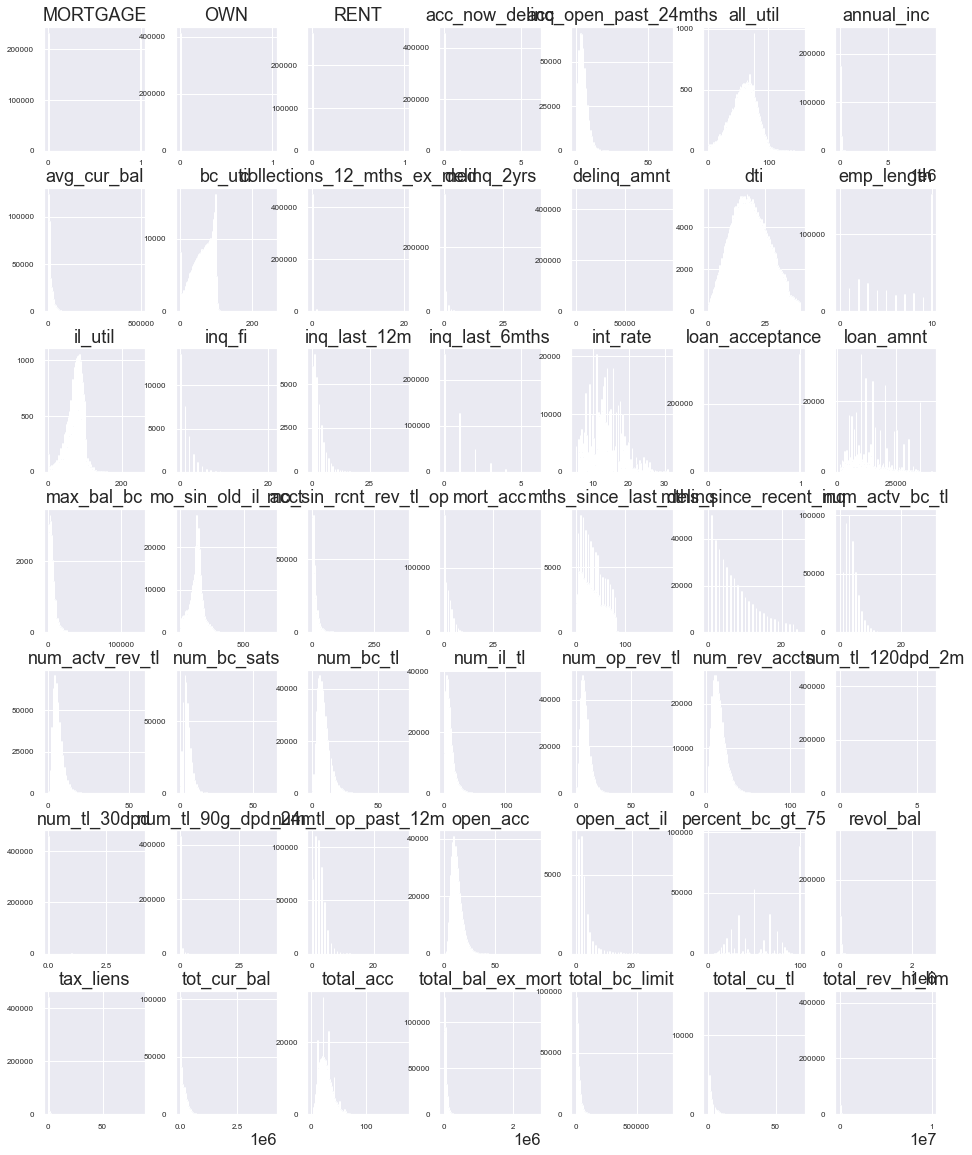

In [47]:
sn.set_style("dark")
df_ind.hist(figsize = (16, 20), bins = 150, xlabelsize = 8, ylabelsize = 8);

### Correlation Matrix

In [48]:
df_ind.corr()

,loan_acceptance,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_util,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,...,tax_liens,tot_cur_bal,total_acc,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_rev_hi_lim,MORTGAGE,OWN,RENT
loan_acceptance,1.000000,-0.005776,-0.100671,-0.139275,0.046918,0.086341,-0.087397,-0.016250,-0.024632,-0.001065,...,-0.010676,0.076605,0.017159,-0.003437,0.077837,0.042634,0.055525,0.076213,-0.007279,-0.073232
acc_now_delinq,-0.005776,1.000000,-0.003052,-0.031050,0.014104,0.016817,-0.030187,0.017111,0.127188,0.157997,...,0.005792,0.023965,0.026712,0.011028,0.004537,0.002067,0.008662,0.015809,0.000382,-0.016369
acc_open_past_24mths,-0.100671,-0.003052,1.000000,-0.050587,0.044414,-0.097565,-0.158689,0.010836,-0.061258,-0.001576,...,0.005319,0.072119,0.426584,0.145682,0.028876,0.147286,0.076003,0.051485,0.002183,-0.053894
all_util,-0.139275,-0.031050,-0.050587,1.000000,0.000465,0.087316,0.598710,-0.021357,0.015778,-0.014624,...,0.003982,0.093768,-0.003100,0.307580,-0.291726,0.058605,-0.234262,0.005193,-0.051501,0.029625
annual_inc,0.046918,0.014104,0.044414,0.000465,1.000000,0.324151,-0.006501,-0.005303,0.045026,0.006604,...,0.038101,0.409552,0.172420,0.320943,0.279124,0.037992,0.281022,0.146583,-0.026938,-0.132771
avg_cur_bal,0.086341,0.016817,-0.097565,0.087316,0.324151,1.000000,0.068699,-0.013967,0.049446,0.020000,...,0.002477,0.837956,0.049047,0.288167,0.153431,0.052915,0.209646,0.443242,-0.058427,-0.415841
bc_util,-0.087397,-0.030187,-0.158689,0.598710,-0.006501,0.068699,1.000000,-0.032536,-0.011922,-0.008622,...,-0.009668,0.039757,-0.091544,0.083506,-0.239669,-0.001498,-0.161316,0.015698,-0.041713,0.009995
collections_12_mths_ex_med,-0.016250,0.017111,0.010836,-0.021357,-0.005303,-0.013967,-0.032536,1.000000,0.059855,0.003789,...,0.012601,-0.012403,0.006716,-0.014383,-0.028160,-0.007739,-0.019871,-0.007656,0.001342,0.006976
delinq_2yrs,-0.024632,0.127188,-0.061258,0.015778,0.045026,0.049446,-0.011922,0.059855,1.000000,0.030822,...,0.012017,0.059919,0.118060,0.029097,-0.077257,0.018986,-0.045702,0.046713,-0.005588,-0.044181
delinq_amnt,-0.001065,0.157997,-0.001576,-0.014624,0.006604,0.020000,-0.008622,0.003789,0.030822,1.000000,...,0.002162,0.019796,0.007090,0.002378,0.000317,-0.005367,0.000880,-0.000372,-0.000834,0.000900


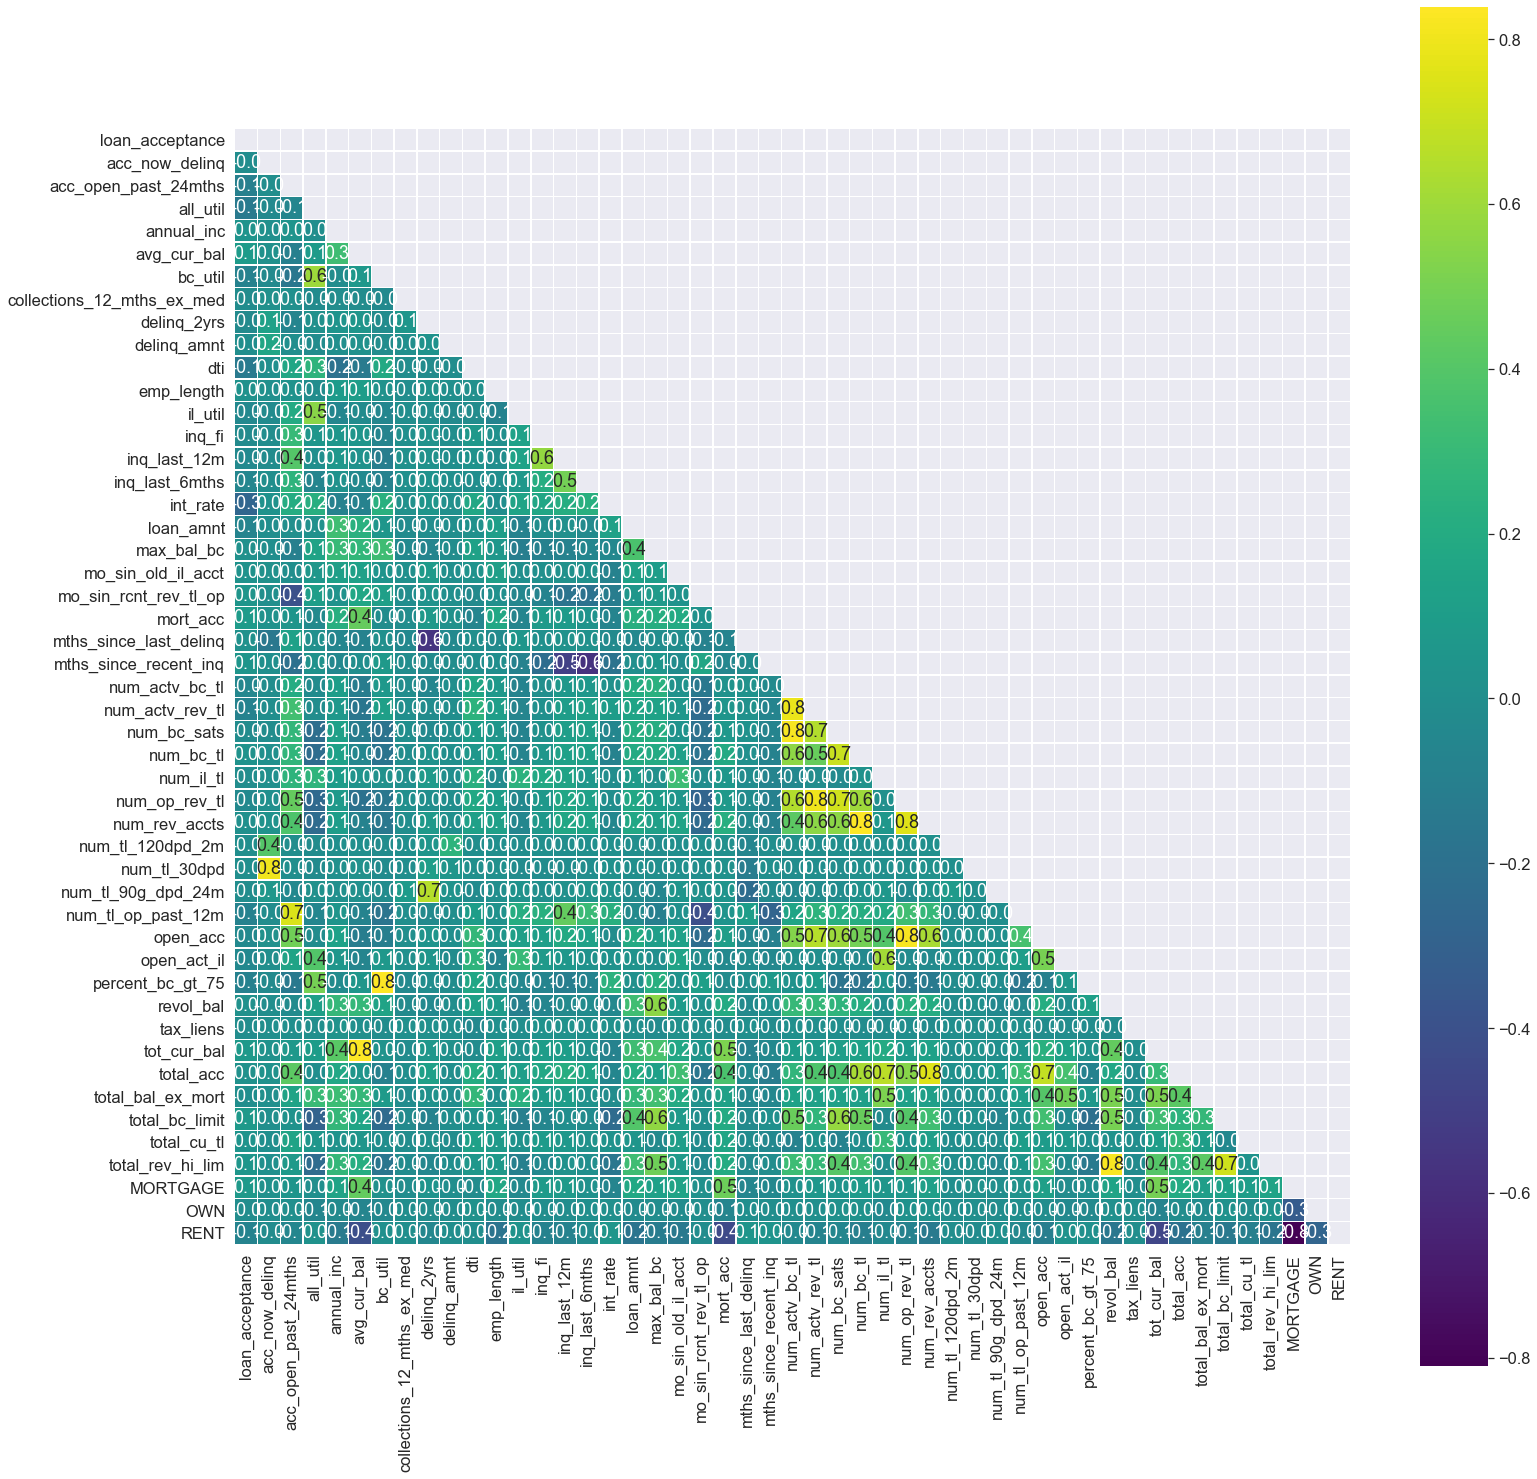

In [49]:
    # Generamos una mask para el triángulo superior
mask = np.triu(np.ones_like(df_ind.corr(), dtype = bool))
            # np.triu(): Devuelve una copia de una matriz con los elementos debajo de la diagonal "K"-ésima en ceros.
            # np.ones_like(): Devuelve un array de unos con el mismo tamaño y tipo que el array principal (data.corr())
    
    
    # Generamos el tamaño de la figura
f, ax = plt.subplots(figsize=(25, 25))

    # Dibujamos el mapa de calor
sn.heatmap(df_ind.corr(), annot = True, fmt = '.1f', mask = mask, square = True, linewidths = .5, cmap = "viridis");
            # annot = True/False: si queremos los valores de las correlaciones ponemos True, por defecto viene False
            # fmt '.Nf' es para decir cuántos decimales queremos en cada cuadrado
            # mask = ...: Si añadimos una mask, los datos no se mostrarán en las celdas donde sea True
            # square = True: es para obtener cuadrados, es decir 1:1
            # linewidht = N: es el ancho de la linea entre cuadrados
            # cmap = "": tema que queremos escoger
        

### Pairplots - int_rate, loan_amnt, tot_cur_bal, total_bc_limit

In [57]:
sample_df_ind = df_ind.iloc[1:2500,]

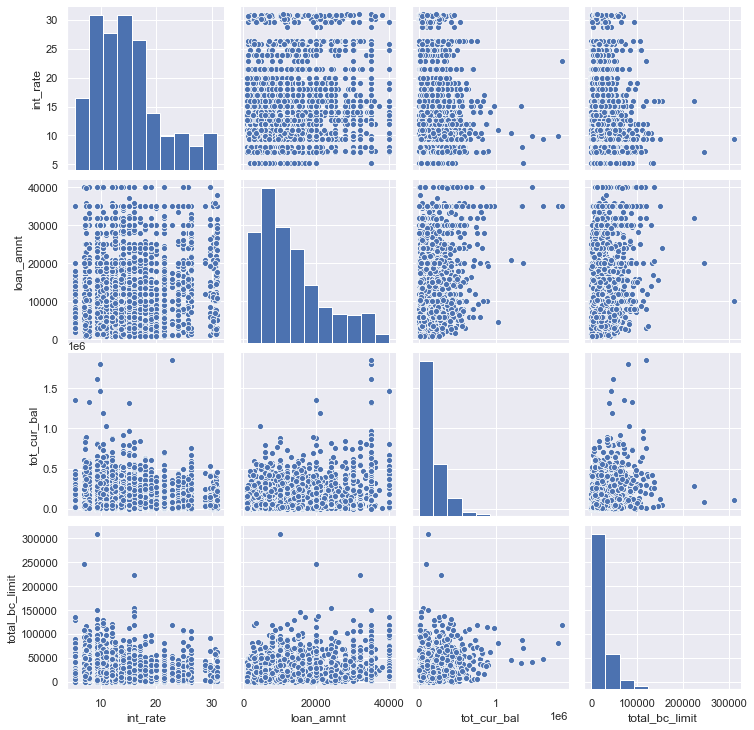

In [56]:
data_pairplot = sample_df_ind.loc[:,['int_rate','loan_amnt','tot_cur_bal','total_bc_limit']] #,
sn.pairplot(data_pairplot, palette = "viridis");  # 

### Jointplot

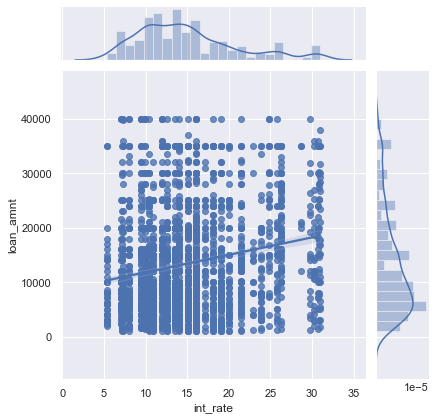

In [55]:
sn.jointplot(x = 'int_rate', y = 'loan_amnt', data = sample_df_ind, kind = 'reg')
sn.set(rc={'figure.figsize':(25,25)})

<a name= 'sixth-bullet'></a>

## 6. Dataframes conversion

Dataframe escalado, sin valores nulos (cambiados por la mediana) y con 56 variables (PARA INDIVIDUAL)


In [ ]:
# df_ind_esc.to_csv('BB.DD_MODELOS.csv') #guardar csv

In [ ]:
df_ind_esc.head(5)

Dataframe sin escalar y con valores nulos para individuales

In [ ]:
df_ind.head(5)

In [ ]:
lista_final = ['loan_acceptance,','acc_now_delinq','acc_open_past_24mths','all_util','annual_inc','avg_cur_bal','bc_util',
             'collections_12_mths_ex_med','delinq_2yrs', 'delinq_amnt','dti','emp_length',
             'il_util','inq_fi','inq_last_12m','inq_last_6mths','int_rate','loan_amnt','max_bal_bc',
             'mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op','mort_acc','mths_since_last_delinq',
             'mths_since_recent_inq','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',
             'num_il_tl','num_op_rev_tl','num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd',
             'num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_act_il','percent_bc_gt_75',
             'revol_bal','tax_liens','tot_cur_bal','total_acc','total_bal_ex_mort',
             'total_bc_limit','total_cu_tl','total_rev_hi_lim','MORTGAGE', 'OWN', 'RENT']

<a name= 'seventh-bullet'></a>

# 7. Bibliography

__Visualización:__

* https://relopezbriega.github.io/blog/2016/09/18/visualizaciones-de-datos-con-python/

* https://todoia.es/guia-completa-de-visualizacion-de-datos-con-python/

* http://seaborn.pydata.org/tutorial/aesthetics.html

__OneHot Encoding:__

* https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/

* https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809

__Modelos Predictivos:__

* https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

* https://medium.com/@benfenison/gridsearching-a-random-forest-classifier-fc225609699c

* https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

__Pipelines:__

* https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

__Lending Club:__

* https://www.kaggle.com/wordsforthewise/lending-club

* https://github.com/harrinac/lending_club_analysis

* https://github.com/harrinac/lending_club_analysis/blob/master/Lending_Club_Data_Exploration_1.ipynb





